<h1>Group 37 Project Report: An Empirical Analysis of Pulsar Signalling <h1>

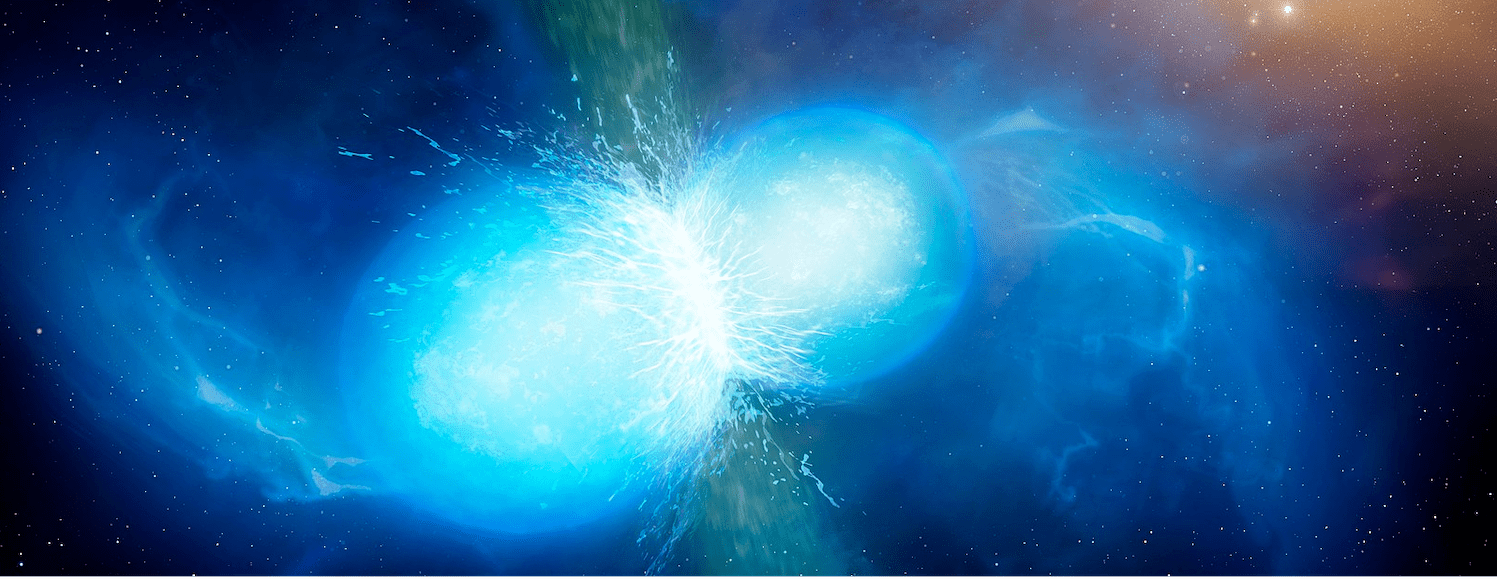

<font size="2"> <i>image attribution</i>: University of Warwick/Mark Garlick, CC BY 4.0 <https://creativecommons.org/licenses/by/4.0>, via Wikimedia Commons </font>

*Total Word Count: 951*

Pulsars are a rare type of neutron star that rotates while emitting electromagnetic radiation. When directed at the earth, these  emissions can be picked up by radio telescopes, producing radio waves of recognizable frequencies.
Unfortunately, however, these frequencies are difficult to separate from terrestrial radio interference, making it difficult for astronomers to detect veritable pulsars. <br>

To investigate this phenomenon statistically, our group posed the question: **"How accurate is KNN classification at differentiating pulsar emissions from interference?"** using a K-nearest neighbors (KNN) algorithm to differentiate pulsar from terrestrial emissions. <br>

This was done using the *HTRU2 Dataset* collected by Dr. Robert Lyon. <br>
This data frame has nine columns, including eight quantitative columns and one class column. The column names are shown below (Machine Learning Repository, n.d.): <br>

<ol>
  <li>Mean of the integrated profile</li>
  <li>Standard deviation of the integrated profile</li>
  <li>Excess kurtosis of the integrated profile</li>
  <li>Skewness of the integrated profile</li>
  <li>Mean of the DM-SNR curve</li>
  <li>Standard deviation of the DM-SNR curve</li>
  <li>Excess kurtosis of the DM-SNR curve</li>
  <li>Skewness of the DM-SNR curve</li>
  <li>Class</li>
</ol>

<h3>Methods & Results<h3>

First, we perform some bookkeeping - importing the necessary packages, before setting a *seed* of 3333 for reproducibility. <br>


In [1]:
#Done to remove warning messages from the proposal and improve readability
options(warn=-1)
options(repr.matrix.max.rows = 6, repr.matrix.max.cols = 10)
library(tidyverse)
library(tidymodels)
set.seed(3333)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.17
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3      ✔ yardstick 0.0.7 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::

Next, we download the HTRU2 zip file from the dataset URL using *download.file()*, unzip using the *unz()* function, before loading our data frame with *read_csv()* load our data frame. Column names have been abbreviated as follows to improve readability: <br /> 
<ol>
  <li>Integrated Profile &rarr; IP</li>
  <li>Standard Deviation &rarr; sd</li>
  <li>DM-SNR curve &rarr; DM-SNR</li>
</ol>

In [2]:
HTRU2_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"

download.file(HTRU2_url, destfile = "HTRU_2.zip") 

#Unz used here as the downloaded file in question is not a raw csv file - but a .zip file with a csv file inside
HTRU_df <- unz("HTRU_2.zip", "HTRU_2.csv") %>% 
    read_csv(col_names = c("IP mean",
                           "IP sd",
                           "IP excess kurtosis",
                           "IP skewness",
                           "DM-SNR mean",
                           "DM-SNR sd",
                           "DM-SNR excess kurtosis",
                           "DM-SNR skewness",
                           "Class"))

Parsed with column specification:
cols(
  `IP mean` = col_double(),
  `IP sd` = col_double(),
  `IP excess kurtosis` = col_double(),
  `IP skewness` = col_double(),
  `DM-SNR mean` = col_double(),
  `DM-SNR sd` = col_double(),
  `DM-SNR excess kurtosis` = col_double(),
  `DM-SNR skewness` = col_double(),
  Class = col_double()
)



Although this dataset is already **tidy**,  three wrangling improvements are made:
<ol>
  <li>Spaces are removed from column names </li>
  <li>Class values (0 and 1) are replaced by "<b>Pulsar Star</b>" and "<b>Interference</b>" (as defined by metadata) </li>
  <li>The class column is converted to a factor datatype </li>
</ol>

In [3]:
#The make.names() function is used here to enter column names into a wrangleable format
colnames(HTRU_df) <- make.names(colnames(HTRU_df))

#the ifelse() function is used here to read the 0 or 1 class values, then exchange with "Pulsar Star" or "Interference" characters respectively
pulsar_df <- HTRU_df %>%
    mutate(Class = as.factor(ifelse(Class == 1, "Pulsar Star", "Interference")))


<h4><b>Table 1</b> - Aggregated Pulsar and Interference Data<h4>

In [4]:
pulsar_df

IP.mean,IP.sd,IP.excess.kurtosis,IP.skewness,DM.SNR.mean,DM.SNR.sd,DM.SNR.excess.kurtosis,DM.SNR.skewness,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,Interference
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,Interference
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,Interference
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,Interference
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,Interference
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,Interference


Then, split the data into training (75%) and testing (25%) datasets using the *initial_split()* function

In [5]:
pulsar_split <- initial_split(pulsar_df, prop = 0.75, strata = Class) 
pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)

Before diving into classification, we need to first perform some preliminary data analysis to determine the **class frequencies**, **mean predictor values**, and the **number of rows of missing data.**

**Number of Observations Per Class**

In [6]:
n_obs_df <- pulsar_training %>%
    group_by(Class) %>%
    summarize(Class.Frequency = n())

total_n <- n_obs_df %>%
    select(Class.Frequency) %>%
    colSums()

frequency_df <- mutate(n_obs_df, Percent.Class.Frequency = round((Class.Frequency/total_n)*100, digits = 0))

`summarise()` ungrouping output (override with `.groups` argument)



<h4><b>Table 2</b> - Pulsar and Interference Frequency<h4>

In [7]:
frequency_df

Class,Class.Frequency,Percent.Class.Frequency
<fct>,<int>,<dbl>
Interference,12183,91
Pulsar Star,1241,9


As can be seen in the table above, there is a large discrepancy between the number of **interference** values (91%) and the number of **pulsar star** values (9%). <br> As K nearest neighbors classification performs poorly under class imbalance, *upsampling* will thus be performed using the **themis** package - duplicating pulsar star observations to increase the 'weight' they hold to affect the classification of new observations

**Mean Predictor Values**

In [8]:
mean_df <- pulsar_training %>%
    select(-Class) %>%
    map_df(mean, na.rm  = TRUE)

<h4><b>Table 3</b> - Pulsar and Interference Mean Predictor Values<h4>

In [9]:
mean_df

IP.mean,IP.sd,IP.excess.kurtosis,IP.skewness,DM.SNR.mean,DM.SNR.sd,DM.SNR.excess.kurtosis,DM.SNR.skewness
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
110.8804,46.47313,0.4866102,1.822736,12.67116,26.32348,8.328325,105.6463


Considering the breadth in values across all variables, we'll need to *standardize* each to improve classification - setting the mean to 0 and standard deviation to 1 when creating our recipe. Additionally, as this dataset has been reviewed by human annotators there are no missing values present.

 With that out of the way, let's perform some introductory forward selection.

**Forward Selection**

In order to choose the variables that make the classifier the most accurate, here we use forward selection- iteratively building up a model by adding one predictor variable at a time (Campell et al., 2021). 

This process involves the following steps (Campell et al., 2021): <br>
1. Start with a model having no predictors 
2. Run the following 3 steps until you run out of predictors: 
   a. for each unused predictor, add it to the model to form a candidate model
   b. tune all of the candidate models
   c. update the model to be the candidate model with the highest cross-validation accuracy
3. select the model that provides the best trade-off between accuracy and simplicity 

In [10]:
p_cols <- colnames(pulsar_training %>% select(-Class))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                set_engine("kknn") %>%
                set_mode("classification")

pulsar_vfold <- vfold_cv(pulsar_training, v = 5, strata = Class)

selected <- c()

for (i in 1:length(p_cols)) {
    
    accs <- list()
    models <- list()
    
    for (j in 1:length(p_cols)) {
        
        preds_new <- c(selected, p_cols[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))
        
        pulsar_recipe <- recipe(as.formula(model_string), data = pulsar_training) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())
        
        acc <- workflow() %>%
                        add_recipe(pulsar_recipe) %>%
                        add_model(knn_spec) %>%
                        tune_grid(resamples = pulsar_vfold, grid = 10) %>%
                        collect_metrics() %>%
                        filter(.metric == "accuracy") %>%
                        summarize(mx = max(mean))
        
        acc <- acc$mx %>% unlist()
        
        accs[[j]] <- acc
        
        models[[j]] <- model_string        
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
                    add_row(size = i, 
                            model_string = models[[jstar]], 
                            accuracy = accs[[jstar]])
    selected <- c(selected, p_cols[[jstar]])
    p_cols <- p_cols[-jstar]    
}

<h4><b>Table 4</b> - Pulsar Forward Selection Accuracy Values<h4>

In [12]:
options(repr.matrix.max.rows = 10, repr.matrix.max.cols = 10)
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Class ~ IP.excess.kurtosis,0.9774286
2,Class ~ IP.excess.kurtosis+IP.mean,0.9798124
3,Class ~ IP.excess.kurtosis+IP.mean+DM.SNR.sd,0.9801847
4,Class ~ IP.excess.kurtosis+IP.mean+DM.SNR.sd+DM.SNR.skewness,0.9801103
5,Class ~ IP.excess.kurtosis+IP.mean+DM.SNR.sd+DM.SNR.skewness+IP.skewness,0.9796633
6,Class ~ IP.excess.kurtosis+IP.mean+DM.SNR.sd+DM.SNR.skewness+IP.skewness+DM.SNR.mean,0.9789184
7,Class ~ IP.excess.kurtosis+IP.mean+DM.SNR.sd+DM.SNR.skewness+IP.skewness+DM.SNR.mean+IP.sd,0.9787694
8,Class ~ IP.excess.kurtosis+IP.mean+DM.SNR.sd+DM.SNR.skewness+IP.skewness+DM.SNR.mean+IP.sd+DM.SNR.excess.kurtosis,0.9786204


According to the descending accuracies column in the table above, accuracy increases only for the first three predictors. By reviewing the parallel variable, we were able to decide on our choice of predictors for this investigation - choosing the following variables for their positive influence upon pulsar prediction:

<ol>
  <li><b>Excess Kurtosis of the Integrated Profile </b></li>
  <li><b>Mean of the Integrated Profile</b></li>
  <li><b>Mean of the DM-SNR curve</b></li>
</ol>

Our training and testing data is constricted below to reflect these findings:

In [10]:
pulsar_training <- select(pulsar_training, "IP.mean",
                                           "IP.excess.kurtosis",
                                           "DM.SNR.mean",
                                           "Class")
pulsar_testing <- select(pulsar_testing, "IP.mean",
                                           "IP.excess.kurtosis",
                                           "DM.SNR.mean",
                                           "Class")

<h4><b>Table 5</b> - Pulsar Forward Selected Training Data<h4>

In [11]:
options(repr.matrix.max.rows = 6, repr.matrix.max.cols = 10)
pulsar_training

IP.mean,IP.excess.kurtosis,DM.SNR.mean,Class
<dbl>,<dbl>,<dbl>,<fct>
103.01562,0.32332837,3.121237,Interference
136.75000,-0.06841464,3.642977,Interference
88.72656,0.60086608,1.178930,Interference
⋮,⋮,⋮,⋮
122.5547,0.1279781,16.409699,Interference
119.3359,0.1593631,21.430602,Interference
114.5078,0.2011614,1.946488,Interference


To better understand the relationships between the three predictors and pulsar class, we perform an introductory visualization below:

In [82]:
point1 = c(4, 150)

options(repr.plot.width = 15, repr.plot.height = 10)
pulsar_plot <- pulsar_training %>%
    ggplot(aes(x = IP.excess.kurtosis, 
               y = IP.mean, 
               colour = DM.SNR.mean,
               shape = Class)) +
        geom_point(alpha = 0.4, 
                   size = 3.4) +
        scale_shape_manual(values=c(4, 19)) +
        labs(x = "\nExcess Kurtosis of the Integrated Profile (Log Scale)\n", 
             y = "\nMean of the Integrated Profile\n", 
             color = "Mean of the\nDM SNR Curve Scale", 
             shape = "Class") +
#         ggtitle("\nIntegrated Profile Excess Kurtosis and Mean against the DM SNR Curve Mean for Incoming Radio Waves\n") +
          ggtitle("\n") +
        theme(text = element_text(size = 22),
              plot.title = element_text(size = 25, 
                                        face="bold", 
                                        hjust = 0.5))+
        scale_x_log10(limits = c(0.005, 10)) +
        ylim(c(0, 150)) +
        scale_color_gradient2(low = "orange1",
                              mid = "deepskyblue2",
                              high = "steelblue2", 
                              midpoint = 80)

<h4><b>Figure 1</b> - Integrated Profile Excess Kurtosis and Mean against the DM SNR Curve Mean for Incoming Radio Waves<h4>

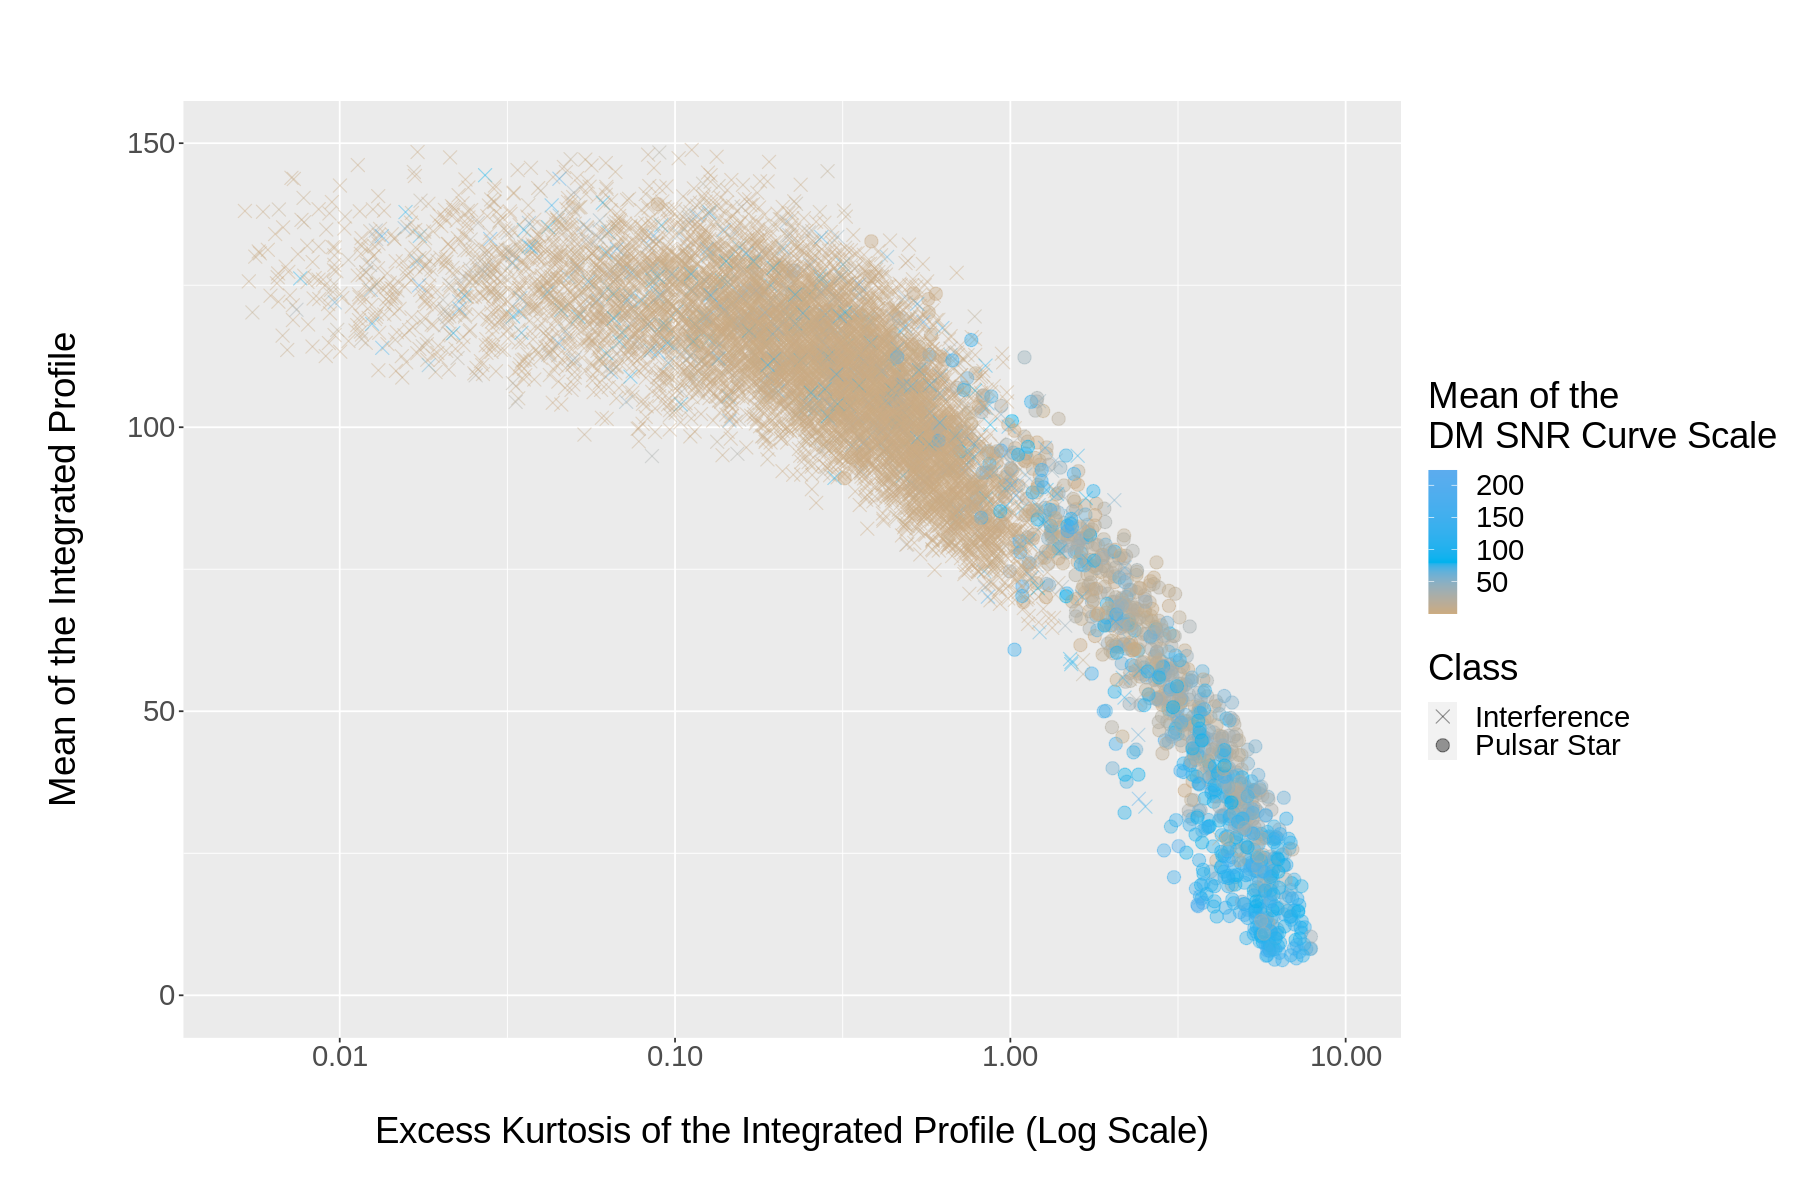

In [83]:
pulsar_plot

As our predictor domain-space spans 3 dimensions, we have instead chosen to model the 3rd dimension (**Mean of the DM SNR Curve**) using colour - with low values coloured in beige, and high values represented by bluer hues. <br>
To then represent our **intereference** and **pulsar** classes, we have opted to change point shape: representing **intereference** points with crosses, and **pulsar** points with standard circles. <br>
Viewing the graph above, there is undoubtedly a relationship between **pulsar** classification and the three predictors yielded from cross validation. It seems that pulsar stars have a high **Excess Kurtosis of the Integrated Profile**, a high **Mean of the DM SNR Curve**, and a low **Mean of the Integrated Profile**. <br>
With that out of the way, it's time to create our  K-Nearest Neighbours algorithm with the selected training data:

**Recipe**

In order to offset the class imbalance present between **pulsar** readings and the more common **interference** ones, we apply the *Themis* package to upsample our data - duplicating pulsar observations to raise their power to affect new observations. <br>

However, this will **not** be baked into our cross validation data during hyperparameter selection. If we were to prep and bake oversampled training data and subsequently perform cross validation, we would return the highest-accuracy K value of 1 each time. **Why?** Because of data leakage. As duplicate points of the infrequent class are spread throughout the training set, some will inevitably enter the validation set - allowing our algorithm to test on duplicate points it has already trained on. <br>
To prevent this, upsampling will be performed through our recipe directly.

In [26]:
pulsar_recipe <- recipe(Class ~ ., data = pulsar_training) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors()) %>%
    themis::step_upsample(Class, over_ratio = 0.2)

**Model Specification**

In [27]:
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

**Workflow Metrics & Cross Validation**

As this first workflow will be used to determine the optimal value of k, we will consider 10 folds, using even k values from 1 to 50.

In [28]:
pulsar_vfold <- vfold_cv(pulsar_training, v = 5, strata = Class)
gridvals <- tibble(neighbors = seq(from = 2, to = 40, by = 2))

accuracies <- workflow() %>%
    add_model(pulsar_spec) %>%
    add_recipe(pulsar_recipe) %>%
    tune_grid(resamples = pulsar_vfold, grid = gridvals) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy") %>%
    arrange(desc(mean))

best_k_value <- slice(accuracies, 1) %>%
    pull(neighbors)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
40,accuracy,binary,0.9796632,5,0.001133935,Model20
36,accuracy,binary,0.9791417,5,0.001178285,Model18
38,accuracy,binary,0.9791417,5,0.001178285,Model19
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6,accuracy,binary,0.9670739,5,0.0017960507,Model03
2,accuracy,binary,0.9662547,5,0.0009736114,Model01
4,accuracy,binary,0.9641688,5,0.0011907826,Model02


[1] "Best K Value:  40"


In [75]:
options(repr.matrix.max.rows = 6, repr.matrix.max.cols = 10)
accuracies
print(paste("Best K Value: ", as.character(best_k_value)))

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
40,accuracy,binary,0.9796632,5,0.001133935,Model20
36,accuracy,binary,0.9791417,5,0.001178285,Model18
38,accuracy,binary,0.9791417,5,0.001178285,Model19
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6,accuracy,binary,0.9670739,5,0.0017960507,Model03
2,accuracy,binary,0.9662547,5,0.0009736114,Model01
4,accuracy,binary,0.9641688,5,0.0011907826,Model02


[1] "Best K Value:  40"


Given this best K-value of 40, we then update our model specifications to match this value - applying upsampling in the process before training

In [29]:
pulsar_upsampling <- recipe(Class ~ ., data = pulsar_training) %>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors()) %>%
    themis::step_upsample(Class, over_ratio = 0.5)

pulsar_spec_updated <- nearest_neighbor(weight_func = "rectangular", neighbors = 40) %>%
    set_engine("kknn") %>%
    set_mode("classification")

pulsar_fit <- workflow() %>%
    add_model(pulsar_spec_updated) %>%
    add_recipe(pulsar_upsampling) %>%
    fit(data = pulsar_training)

pulsar_metrics <- pulsar_fit %>%
    predict(pulsar_testing) %>%
    bind_cols(pulsar_testing) %>%
    metrics(truth = Class, estimate = .pred_class)  

pulsar_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9713903
kap,binary,0.8262518


In [30]:
pulsar_training

IP.mean,IP.excess.kurtosis,DM.SNR.mean,Class
<dbl>,<dbl>,<dbl>,<fct>
103.01562,0.32332837,3.121237,Interference
136.75000,-0.06841464,3.642977,Interference
88.72656,0.60086608,1.178930,Interference
⋮,⋮,⋮,⋮
122.5547,0.1279781,16.409699,Interference
119.3359,0.1593631,21.430602,Interference
114.5078,0.2011614,1.946488,Interference


Thus, our finalized K nearest neighbors algorithm has been created, that can differentiate between Pulsar and Interference observations with an accuracy of 97.1%. To consider the prediction disribution of our algorithm, we visualize three combinations of the **Mean of Integrated Profile**, **Excess Kurtosis of Integrated Profile**, and **Mean of DM-SNR Curve below**. <br>
To improve our visualization, we install the *cowplot* package, providing us with better visualiziation tools for a side-by-side comparison of our three classifier-prediction plots:

In [ ]:
install.packages("cowplot", dependencies = TRUE)
library(cowplot)

In [61]:
options(repr.plot.width = 8, repr.plot.height = 8)

# create the grid of area/smoothness vals, and arrange in a data frame
ek_grid <- seq(min(pulsar_training$IP.excess.kurtosis), 
                max(pulsar_training$IP.excess.kurtosis), 
                length.out = 80)
ip_mean_grid <- seq(min(pulsar_training$IP.mean), 
                max(pulsar_training$IP.mean), 
                length.out = 80)
dm_mean_grid <- seq(min(pulsar_training$DM.SNR.mean), 
                max(pulsar_training$DM.SNR.mean), 
                length.out = 10)

asgrid <- as_tibble(expand.grid(IP.excess.kurtosis = ek_grid, 
                                IP.mean = ip_mean_grid, 
                                DM.SNR.mean = dm_mean_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(pulsar_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

pulsar_plot_1 <- ggplot() +
  geom_point(data = pulsar_training, 
             mapping = aes(x = IP.excess.kurtosis, 
                           y = IP.mean, 
                           color = Class), 
             alpha = 0.6) +
  geom_point(data = prediction_table, 
             mapping = aes(x = IP.excess.kurtosis, 
                           y = IP.mean, 
                           color = Class), 
             alpha = 0.02, 
             size = 2) +
  labs(color = "Class", 
       x = "Excess Kurtosis of the Integrated Profile", 
       y = "Mean of the Integrated Profile") +
  scale_color_manual(labels = c("Interference", "Pulsar"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 18))

# create the grid of area/smoothness vals, and arrange in a data frame
ek_grid <- seq(min(pulsar_training$IP.excess.kurtosis), 
                max(pulsar_training$IP.excess.kurtosis), 
                length.out = 80)
ip_mean_grid <- seq(min(pulsar_training$IP.mean), 
                max(pulsar_training$IP.mean), 
                length.out = 10)
dm_mean_grid <- seq(min(pulsar_training$DM.SNR.mean), 
                max(pulsar_training$DM.SNR.mean), 
                length.out = 80)

asgrid <- as_tibble(expand.grid(IP.excess.kurtosis = ek_grid, 
                                IP.mean = ip_mean_grid, 
                                DM.SNR.mean = dm_mean_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(pulsar_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

pulsar_plot_2 <-
  ggplot() +
  geom_point(data = pulsar_training, 
             mapping = aes(x = IP.excess.kurtosis, 
                           y = DM.SNR.mean, 
                           color = Class), 
             alpha = 0.6) +
  geom_point(data = prediction_table, 
             mapping = aes(x = IP.excess.kurtosis, 
                           y = DM.SNR.mean, 
                           color = Class), 
             alpha = 0.02, 
             size = 2) +
  labs(color = "Class", 
       x = "Excess Kurtosis of the Integrated Profile", 
       y = "Mean of the DM-SNR Curve") +
  scale_color_manual(labels = c("Interference", "Pulsar"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 18))

# create the grid of area/smoothness vals, and arrange in a data frame
ek_grid <- seq(min(pulsar_training$IP.excess.kurtosis), 
                max(pulsar_training$IP.excess.kurtosis), 
                length.out = 10)
ip_mean_grid <- seq(min(pulsar_training$IP.mean), 
                max(pulsar_training$IP.mean), 
                length.out = 80)
dm_mean_grid <- seq(min(pulsar_training$DM.SNR.mean), 
                max(pulsar_training$DM.SNR.mean), 
                length.out = 80)

asgrid <- as_tibble(expand.grid(IP.excess.kurtosis = ek_grid, 
                                IP.mean = ip_mean_grid, 
                                DM.SNR.mean = dm_mean_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(pulsar_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>%
  rename(Class = .pred_class)

pulsar_plot_3 <-
  ggplot() +
  geom_point(data = pulsar_training, 
             mapping = aes(x = DM.SNR.mean, 
                           y = IP.mean, 
                           color = Class), 
             alpha = 0.6) +
  geom_point(data = prediction_table, 
             mapping = aes(x = DM.SNR.mean, 
                           y = IP.mean, 
                           color = Class), 
             alpha = 0.02, 
             size = 2) +
  labs(color = "Class", 
       x = "Mean of the DM-SNR Curve", 
       y = "Mean of the Integrated Profile") +
  scale_color_manual(labels = c("Interference", "Pulsar"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 18))

<h4><b>Figure 2</b> - Trained KNN Algoirthm Classification Plots Between All Predictors  <h4>

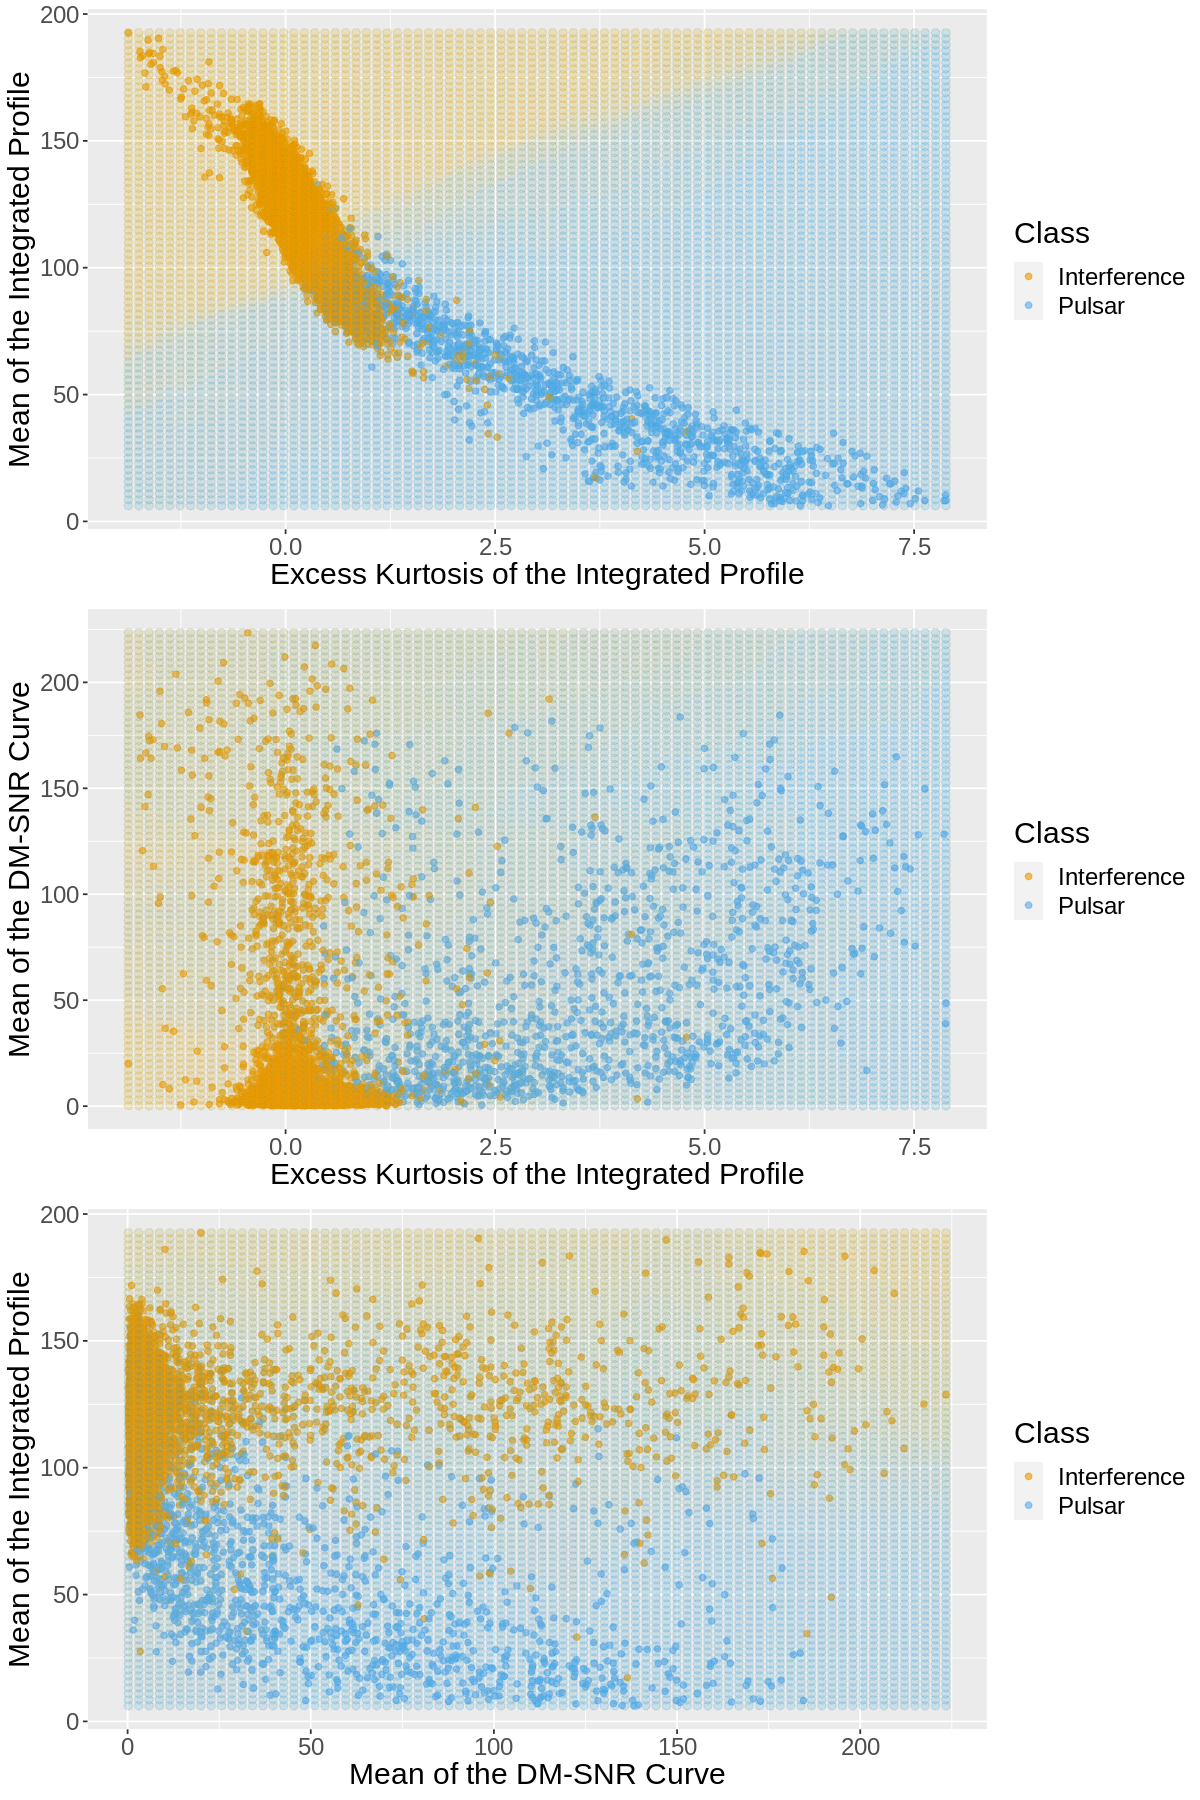

In [62]:
options(repr.plot.width = 10, repr.plot.height = 15)
plot_grid(pulsar_plot_1, pulsar_plot_2, pulsar_plot_3, align = "v", ncol = 1, scale = 1)

With our analysis-visualizations created, 

### 

<h3>References<h3> 

Campbell, T., Lee, M., & Timbers, T. (2021). Data Science: A First Introduction. Retrieved November 28, 2021, from https://ubc-dsci.github.io/introduction-to-datascience/classification2.html#predictor-variable-selection

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple   filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

Machine Learning Repository. (n.d.). HTRU2 Data Set. N.p.: University College London. Retrieved November 4, 2021, from https://archive.ics.uci.edu/ml/datasets/HTRU2

Eatough, R. P., Molkenthin, N., Kramer, M., Noutsos, A., Keith, M. J., Stappers, B. W., & Lyne, A. G. (2010). Selection of radio pulsar candidates using artificial neural networks. Monthly Notices of the Royal Astronomical Society, 407(4), 2443-2450.

Sagan, C. (1994). Pale Blue Dot: A Vision of the Human Future in Space. Random House.